In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans


from sklearn.decomposition import PCA
from umap_batch import UMAP
from utils import re_nn_distance, re_distance_nn

import pandas as pd  
import scipy.sparse as sp
import model
import time

import quantile 

import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [3]:
# read in dataset
dir = '../data/real/vert/mmskin/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)[::10,:]
        print(counts_atac)
        print(counts_atac.shape)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)[::10,:]
        print(counts_rna)
        print(counts_rna.shape)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

counts = {"rna":counts_rnas, "atac": counts_atacs}

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())
# normalize A
A = utils.preprocess(A, modality = "interaction")
interacts = {"rna_atac": A}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions}
counts["feats_name"] = feats_name

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 1 0 0]]
(3478, 4619)
[[0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [2 3 1 ... 0 0 0]
 [0 2 0 ... 0 0 0]]
(3478, 97654)


Input sanity check...
Finished.
Epoch 1000, Validating Loss: 10.8239
	 loss 1: 0.01579
	 loss 2: 0.00102
	 loss 3: -0.99304
Epoch 2000, Validating Loss: 10.7673
	 loss 1: 0.01573
	 loss 2: 0.00127
	 loss 3: -0.99306
Epoch 3000, Validating Loss: 10.7228
	 loss 1: 0.01569
	 loss 2: 0.00277
	 loss 3: -0.99395
Epoch 4000, Validating Loss: 10.6910
	 loss 1: 0.01566
	 loss 2: 0.00312
	 loss 3: -0.99456
Epoch 5000, Validating Loss: 10.6697
	 loss 1: 0.01564
	 loss 2: 0.00273
	 loss 3: -0.99487
Epoch 6000, Validating Loss: 10.6536
	 loss 1: 0.01563
	 loss 2: 0.00240
	 loss 3: -0.99490
Epoch 7000, Validating Loss: 10.6389
	 loss 1: 0.01561
	 loss 2: 0.00205
	 loss 3: -0.99512
Epoch 8000, Validating Loss: 10.6287
	 loss 1: 0.01560
	 loss 2: 0.00269
	 loss 3: -0.99505
Epoch 9000, Validating Loss: 10.6170
	 loss 1: 0.01559
	 loss 2: 0.00209
	 loss 3: -0.99486
Epoch 10000, Validating Loss: 10.6087
	 loss 1: 0.01558
	 loss 2: 0.00183
	 loss 3: -0.99479
running time: 296.8516991138458


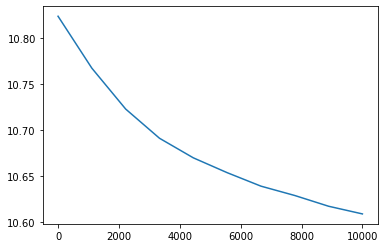

In [4]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 5]
batchsize = 0.1
run = 0
K = 30
Ns = [K] * 2
N_feat = Ns[0]
interval = 1000
T = 10000
lr = 1e-2

# use interaction matrix
start_time = time.time()
model1 = model.cfrm_vanilla(counts = counts, interacts = interacts, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

x = np.linspace(0, T, int(T/interval))
plt.plot(x, losses1)

In [13]:
# umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4, random_state = 0) 
# zs = []
# x_umaps = []
# labels = []
# prec_labels = []
# pre_labels = []
# for batch in range(0,2):
#     z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
#     # z = model1.C_cells[batch].cpu().detach().numpy()
#     zs.append(z)
#     labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
#     pre_labels.append(np.argmax(z, axis = 1).squeeze())
#     x_umaps.append(umap_op.fit_transform(z))

# utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "UMAP")

# utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, figsize = (15,10), axis_label = "UMAP", markerscale = 6)


In [ ]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4, random_state = 0) 
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze()[::10])
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "UMAP")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, figsize = (15,10), axis_label = "UMAP", markerscale = 6)


In [ ]:
n_neighbors = 10

zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().de tach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze()[::10])
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

s_pair_dist, knn_indices, knn_dists = re_nn_distance(zs, n_neighbors)

umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.4, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices)
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,15), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (10,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (10,10), axis_label = "Latent", markerscale = 6)
